# Data Analysis

## Imports

### Sys and Ipython

In [1]:
import sys
import warnings

from IPython.core.interactiveshell import InteractiveShell
from IPython.display import HTML, display

sys.path.insert(0, '../src/')

warnings.filterwarnings('ignore')

InteractiveShell.ast_node_interactivity = "all"

### Graphics

In [2]:
%matplotlib inline

import geopandas as gpd
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
from pandas.plotting import autocorrelation_plot, lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from __init__ import *

### Source files 

In [3]:
%load_ext autoreload

%autoreload 2

from constant import (data_matrix_15m_complete, dict_w, dict_wd_dec,
                      dict_wd_decf, dict_wd_final, dict_wd_nov, dict_wd_novf,
                      dict_wd_oct, subway_stations)
from utils import generate_times

## Loading Data

### Contour Iris

In [4]:
contour_iris = gpd.read_file(
    '../datasets/iris/iris.shp')

convert_to_int = ['dep', 'insee_com', 'iris', 'code_iris']
for col in convert_to_int:
    contour_iris[col] = contour_iris[col].astype(int)

contour_iris = contour_iris[['code_iris', 'geometry', 'dep']]
contour_iris.head();

### Stations and Dates

In [5]:
station_data = pd.read_csv("../datasets/station_to_iris.csv")
station_data.describe();

In [6]:
print("Number of Subway stations: {}".format(len(subway_stations)))

Number of Subway stations: 303


In [7]:
dates = pd.date_range(start="2015-10-01", end="2015-12-31").date

### Discretized Matrix

In [8]:
matrix_6h = np.load("../datasets/6h_matrix.npy")
matrix_2h = np.load("../datasets/2h_matrix.npy")
matrix_15m = np.load("../datasets/15m_matrix.npy")

## Data Analysis and Preprocessing

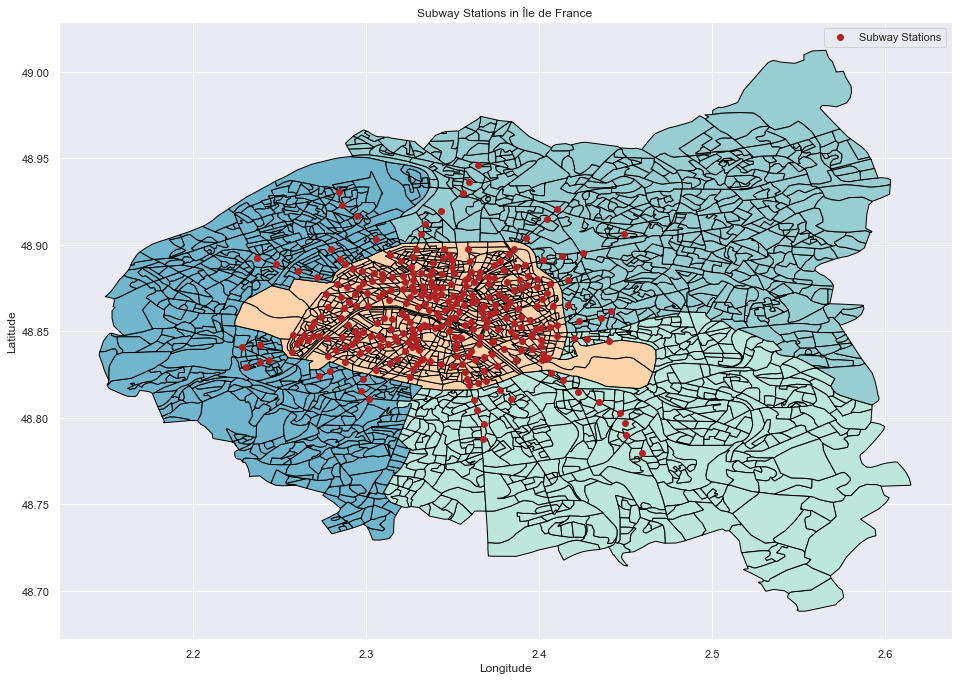

In [9]:
f, ax = plt.subplots(1, figsize=(16, 12))
ax = contour_iris[contour_iris['dep'].isin([75, 92, 93, 94])].plot(
    ax=ax, edgecolor='black', column='dep', cmap='icefire_r')
ax.scatter(station_data[station_data['id'].isin(subway_stations)]['x'],
           station_data[station_data['id'].isin(subway_stations)]['y'], color='firebrick', label='Subway Stations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Subway Stations in Île de France')
ax.legend()

plt.show();

### Creating Panels

In [10]:
data_matrix_6h = pd.Panel(matrix_6h, 
                         items=dates, 
                         major_axis=subway_stations, 
                         minor_axis=generate_times("6h")
                        )

data_matrix_2h = pd.Panel(matrix_2h, 
                         items=dates, 
                         major_axis=subway_stations, 
                         minor_axis=generate_times("2h")
                        )

data_matrix_15m_complete = pd.Panel(matrix_15m, 
                                    items=dates, 
                                    major_axis=subway_stations, 
                                    minor_axis=generate_times("15min")
                                   )

Delete the first $4$ hours, from $00.00.00$ to $04.00.00$ because it's useless, the number of validations in that range is mostly equal to 0.

In [11]:
del_hours = 4

In [12]:
data_matrix_15m = data_matrix_15m_complete.iloc[:, :, del_hours*4:]

In [13]:
data_matrix_15m.to_frame().head()

2015-10-01  2015-10-02  2015-10-03  2015-10-04  2015-10-05  \
major minor                                                                  
198   04:00:00         0.0         3.0         0.0         0.0         0.0   
      04:15:00         0.0         0.0         0.0         0.0         2.0   
      04:30:00         0.0         1.0         0.0         0.0         0.0   
      04:45:00         1.0         2.0         0.0         2.0         1.0   
      05:00:00         7.0        11.0         6.0        12.0        10.0   

                2015-10-06  2015-10-07  2015-10-08  2015-10-09  2015-10-10  \
major minor                                                                  
198   04:00:00         0.0         0.0         2.0         0.0         0.0   
      04:15:00         0.0         0.0         0.0         0.0         0.0   
      04:30:00         0.0         0.0         0.0         0.0         0.0   
      04:45:00         0.0         1.0         0.0         0.0         0.0   
      05:00:00         6.0         9.0        12.0         9.0        13.0   

                   ...      2015-12-22  2015-12-23  2015-12-24  2015-12-25  \
major minor        ...                                                       
198   04:00:00     ...             0.0         0.0         0.0         0.0   
      04:15:00     ...             0.0         0.0         0.0         0.0   
      04:30:00     ...             1.0         1.0         2.0         1.0   
      04:45:00     ...             2.0         0.0         0.0         2.0   
      05:00:00     ...            11.0         9.0         7.0         1.0   

                2015-12-26  2015-12-27  2015-12-28  2015-12-29  2015-12-30  \
major minor                                                                  
198   04:00:00         0.0         0.0         0.0         0.0         0.0   
      04:15:00         0.0         0.0         0.0         0.0         0.0   
      04:30:00         0.0         1.0         0.0         0.0         0.0   
      04:45:00         0.0         0.0         0.0         0.0         0.0   
      05:00:00         5.0        10.0        12.0        10.0        10.0   

                2015-12-31  
major minor                 
198   04:00:00         0.0  
      04:15:00         0.0  
      04:30:00         0.0  
      04:45:00         2.0  
      05:00:00         5.0  

[5 rows x 92 columns]

In [14]:
dmatrix_mean_6h = data_matrix_6h.mean()
dmatrix_mean_2h = data_matrix_2h.mean()
dmatrix_mean_15m = data_matrix_15m.mean()

dtmatrix_mean_6h = dmatrix_mean_6h.transpose()
dtmatrix_mean_2h = dmatrix_mean_2h.transpose()
dtmatrix_mean_15m = dmatrix_mean_15m.transpose()

Again, this is another way to print the stations with a small number of validations.

In [15]:
data_matrix_15m.mean(axis=0)[data_matrix_15m.mean(axis=0).sum(axis=1) < 810];

In [16]:
dmatrix_mean_15m.head()
dtmatrix_mean_15m.head()

2015-10-01  2015-10-02  2015-10-03  2015-10-04  2015-10-05  \
04:00:00    0.112211    0.188119    0.036304    0.392739    0.072607   
04:15:00    0.138614    0.138614    0.029703    0.554455    0.092409   
04:30:00    0.174917    0.148515    0.059406    0.422442    0.075908   
04:45:00    0.376238    0.462046    0.481848    1.072607    0.396040   
05:00:00    2.643564    3.079208    2.458746    3.900990    2.973597   

          2015-10-06  2015-10-07  2015-10-08  2015-10-09  2015-10-10  \
04:00:00    0.095710    0.099010    0.108911    0.108911    0.072607   
04:15:00    0.082508    0.145215    0.072607    0.108911    0.072607   
04:30:00    0.141914    0.141914    0.165017    0.105611    0.102310   
04:45:00    0.501650    0.491749    0.584158    0.590759    0.478548   
05:00:00    3.112211    3.293729    3.468647    3.254125    2.732673   

             ...      2015-12-22  2015-12-23  2015-12-24  2015-12-25  \
04:00:00     ...        0.066007    0.102310    0.066007    0.029703   
04:15:00     ...        0.075908    0.069307    0.056106    0.036304   
04:30:00     ...        0.135314    0.135314    0.128713    0.112211   
04:45:00     ...        0.468647    0.521452    0.442244    0.339934   
05:00:00     ...        2.696370    3.207921    2.920792    1.217822   

          2015-12-26  2015-12-27  2015-12-28  2015-12-29  2015-12-30  \
04:00:00    0.036304    0.013201    0.062706    0.089109    0.069307   
04:15:00    0.013201    0.000000    0.085809    0.089109    0.062706   
04:30:00    0.099010    0.079208    0.161716    0.108911    0.099010   
04:45:00    0.346535    0.346535    0.432343    0.419142    0.409241   
05:00:00    2.019802    1.795380    2.805281    2.993399    3.112211   

          2015-12-31  
04:00:00    0.075908  
04:15:00    0.102310  
04:30:00    0.079208  
04:45:00    0.495050  
05:00:00    2.798680  

[5 rows x 92 columns]

04:00:00  04:15:00  04:30:00  04:45:00  05:00:00   05:15:00  \
2015-10-01  0.112211  0.138614  0.174917  0.376238  2.643564  19.864686   
2015-10-02  0.188119  0.138614  0.148515  0.462046  3.079208  22.399340   
2015-10-03  0.036304  0.029703  0.059406  0.481848  2.458746  14.254125   
2015-10-04  0.392739  0.554455  0.422442  1.072607  3.900990  15.920792   
2015-10-05  0.072607  0.092409  0.075908  0.396040  2.973597  20.858086   

             05:30:00   05:45:00   06:00:00   06:15:00    ...       21:30:00  \
2015-10-01  31.471947  31.874587  40.541254  48.481848    ...      70.927393   
2015-10-02  34.537954  34.650165  41.858086  50.056106    ...      78.590759   
2015-10-03  20.429043  19.184818  22.465347  24.531353    ...      82.211221   
2015-10-04  19.696370  16.963696  16.247525  17.610561    ...      43.570957   
2015-10-05  32.630363  32.729373  39.689769  52.072607    ...      61.039604   

             21:45:00   22:00:00   22:15:00   22:30:00   22:45:00   23:00:00  \
2015-10-01  66.881188  65.399340  60.584158  60.755776  64.207921  75.128713   
2015-10-02  73.495050  70.907591  65.983498  66.211221  62.917492  66.330033   
2015-10-03  77.181518  73.755776  72.805281  74.570957  76.264026  83.947195   
2015-10-04  43.818482  41.745875  37.462046  36.722772  37.283828  52.759076   
2015-10-05  52.346535  53.125413  46.059406  45.498350  41.036304  41.254125   

             23:15:00   23:30:00   23:45:00  
2015-10-01  64.590759  52.138614  43.818482  
2015-10-02  63.188119  57.755776  54.673267  
2015-10-03  80.049505  76.587459  72.772277  
2015-10-04  37.158416  31.211221  25.254125  
2015-10-05  35.336634  28.003300  22.801980  

[5 rows x 80 columns]

### With Outliers

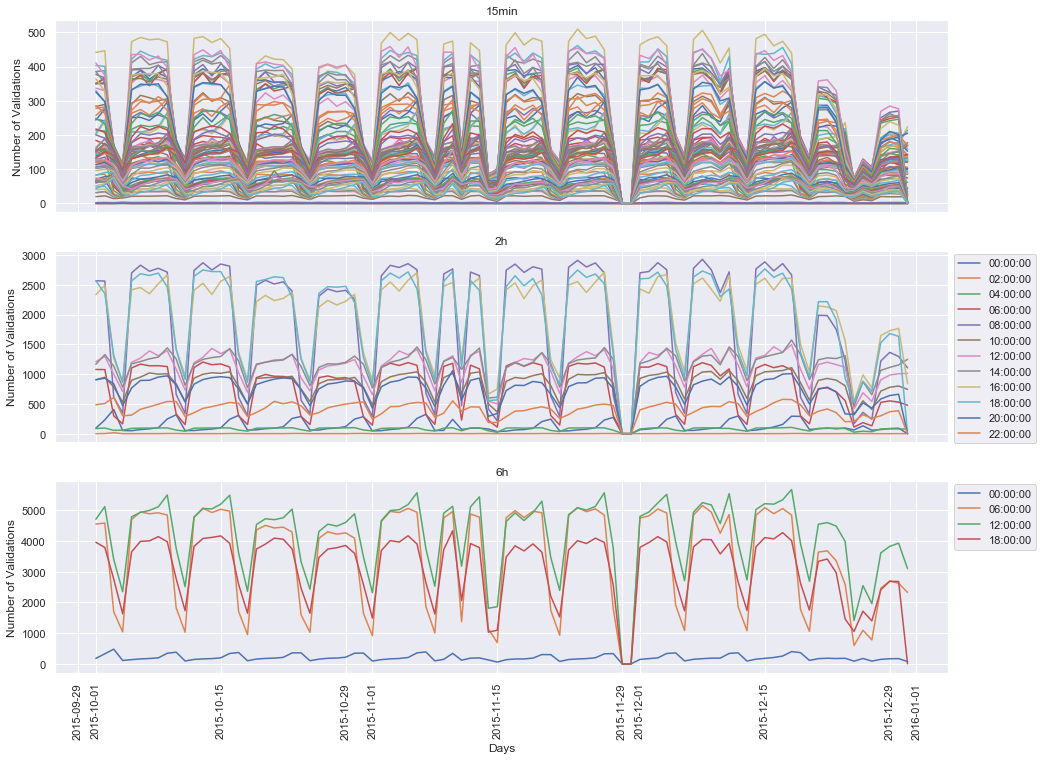

In [17]:
f, ax = plt.subplots(3, figsize=(16, 12))
ax1 = dtmatrix_mean_15m.plot(ax=ax[0], legend=False)
ax1.set_xticklabels([])
ax1.set_ylabel('Number of Validations')
ax1.set_title('15min')

ax2 = dtmatrix_mean_2h.plot(ax=ax[1])
ax2.set_xticklabels([])
ax2.set_ylabel('Number of Validations')
ax2.set_title('2h')
ax2.legend(bbox_to_anchor=(1., 1.01))

ax3 = dtmatrix_mean_6h.plot(ax=ax[2])
ax3.set_xlabel('Days')
ax3.set_ylabel('Number of Validations')
ax3.set_title('6h')
ax3.legend(bbox_to_anchor=(1., 1.01))

plt.xticks(rotation=90)
plt.show();

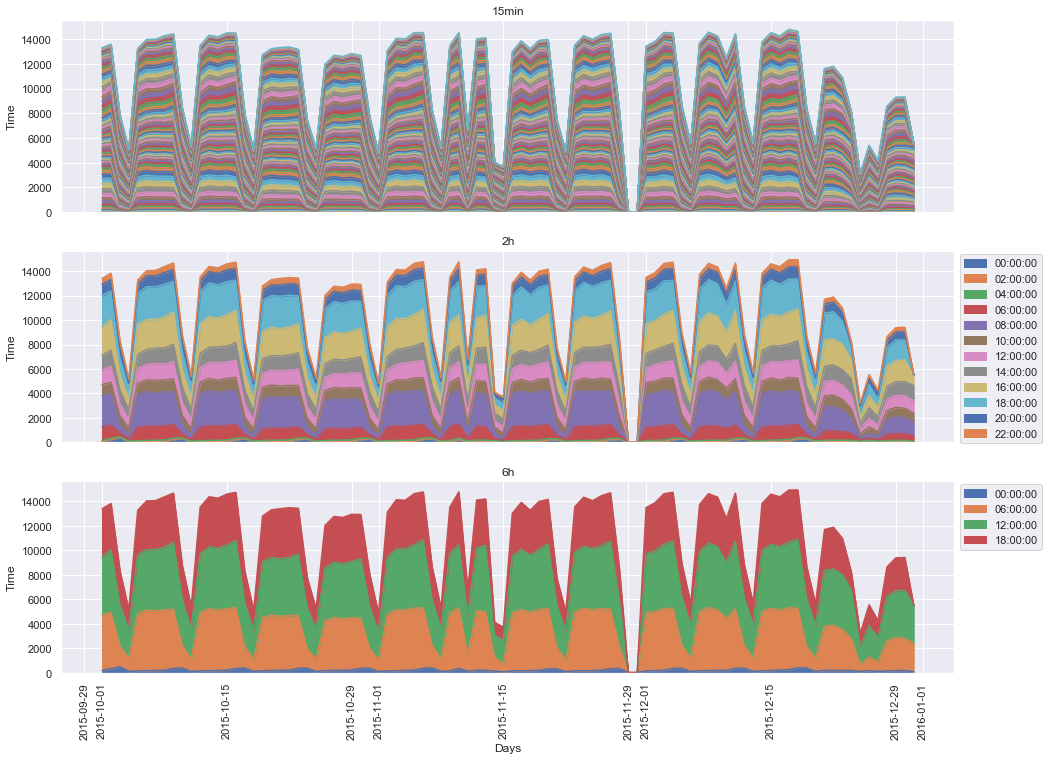

In [18]:
f, ax = plt.subplots(3, figsize=(16, 12))
ax1 = dtmatrix_mean_15m.plot.area(ax=ax[0], legend=False)
ax1.set_xticklabels([])
ax1.set_ylabel('Time')
ax1.set_title('15min')

ax2 = dtmatrix_mean_2h.plot.area(ax=ax[1])
ax2.set_xticklabels([])
ax2.set_ylabel('Time')
ax2.set_title('2h')
ax2.legend(bbox_to_anchor=(1., 1.01))

ax3 = dtmatrix_mean_6h.plot.area(ax=ax[2])
ax3.set_xlabel('Days')
ax3.set_ylabel('Time')
ax3.set_title('6h')
ax3.legend(bbox_to_anchor=(1., 1.01), loc=2)

plt.xticks(rotation=90)
plt.show();

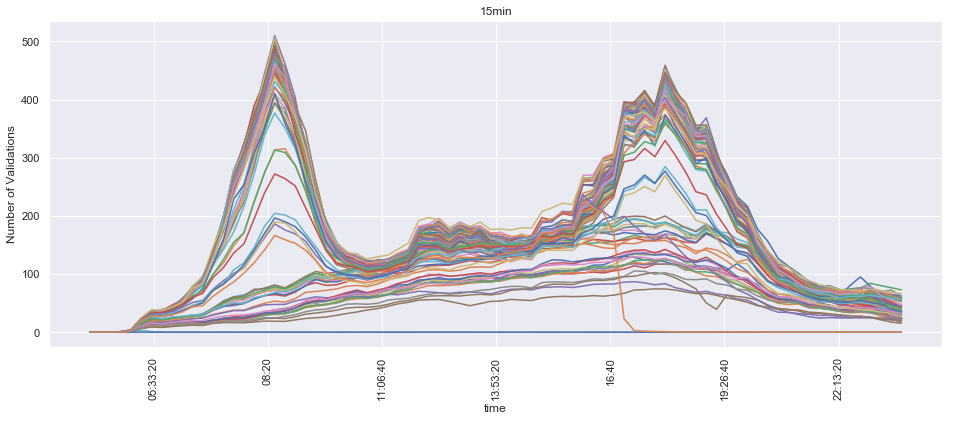

In [19]:
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0])
dmatrix_mean_15m.plot(ax=ax, legend=False)
plt.ylabel('Number of Validations')
plt.title('15min')

plt.xticks(rotation=90)
plt.show();

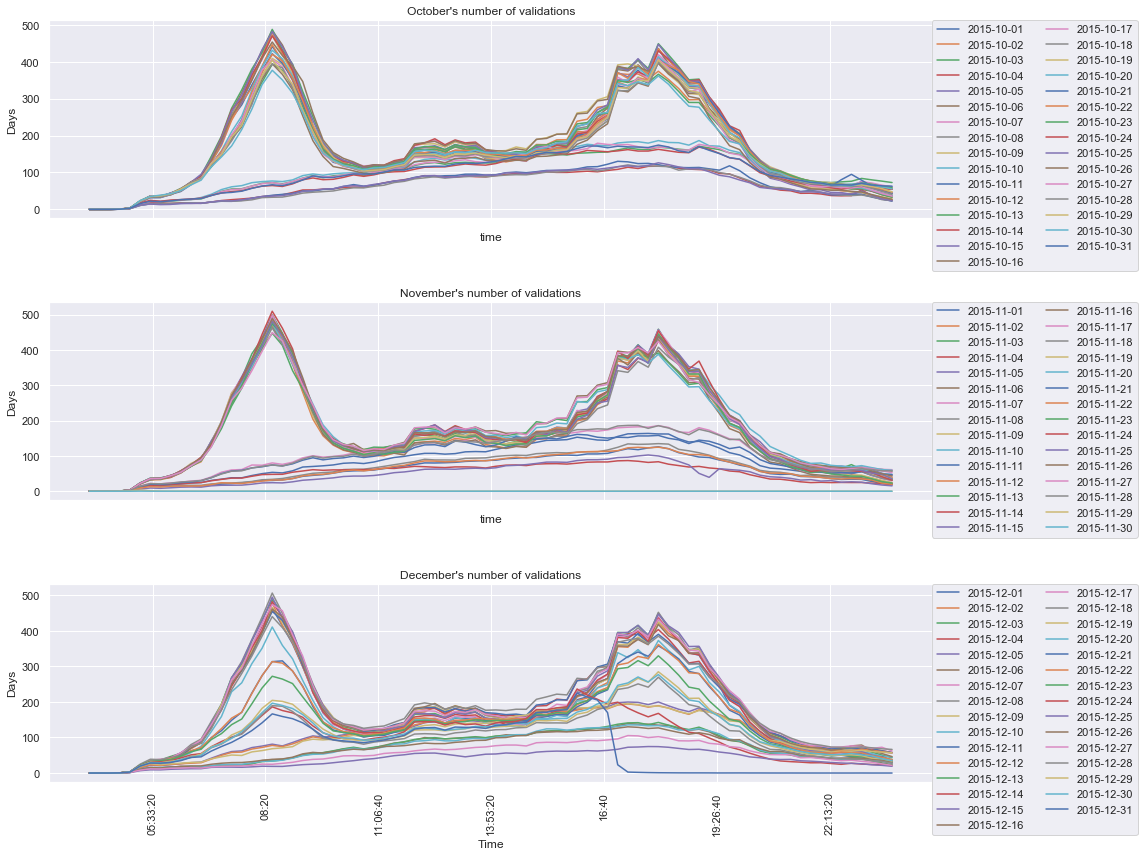

In [20]:
f, ax = plt.subplots(3, figsize=(16, 12))
ax1 = dmatrix_mean_15m.iloc[:, :31].plot(ax=ax[0])
ax1.set_xticklabels([])
ax1.set_ylabel('Days')
ax1.set_title('October\'s number of validations')
ax1.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)


ax2 = dmatrix_mean_15m.iloc[:, 31:61].plot(ax=ax[1])
ax2.set_xticklabels([])
ax2.set_ylabel('Days')
ax2.set_title('November\'s number of validations')
ax2.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

ax3 = dmatrix_mean_15m.iloc[:, 61:].plot(ax=ax[2])
ax3.set_xlabel('Time')
ax3.set_ylabel('Days')
ax3.set_title('December\'s number of validations')
plt.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), loc=2,
           ncol=2, borderaxespad=0.)

plt.xticks(rotation=90)
plt.tight_layout()

plt.show();

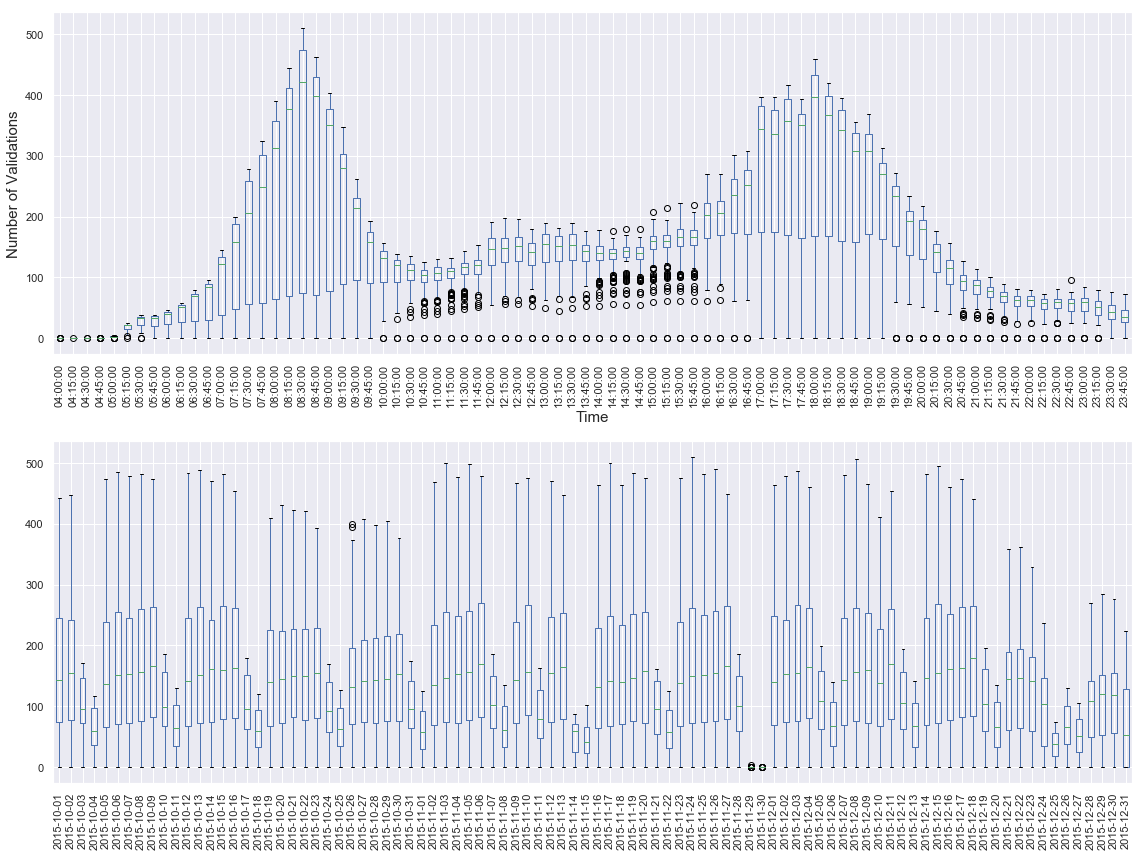

In [21]:
f, ax = plt.subplots(2, figsize=(16, 12))

ax1 = dtmatrix_mean_15m.boxplot(return_type='both', ax=ax[0])
ax[0].set_xlabel("Time", fontsize=15)
ax[0].set_ylabel("Number of Validations", fontsize=15)

for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)

ax2 = dmatrix_mean_15m.boxplot(return_type='both', ax=ax[1])
plt.xticks(rotation=90)

plt.tight_layout()
plt.show();

### Defining useful variables

In [22]:
wd_15m = data_matrix_15m.loc[dict_w.values()]
wdm_15m = wd_15m.mean()
wdmt_15m = wdm_15m.transpose()

wd_15mf = data_matrix_15m.loc[dict_wd_final.values()]
wdm_15mf = wd_15mf.mean()
wdmt_15mf = wdm_15mf.transpose()

### Without outliers

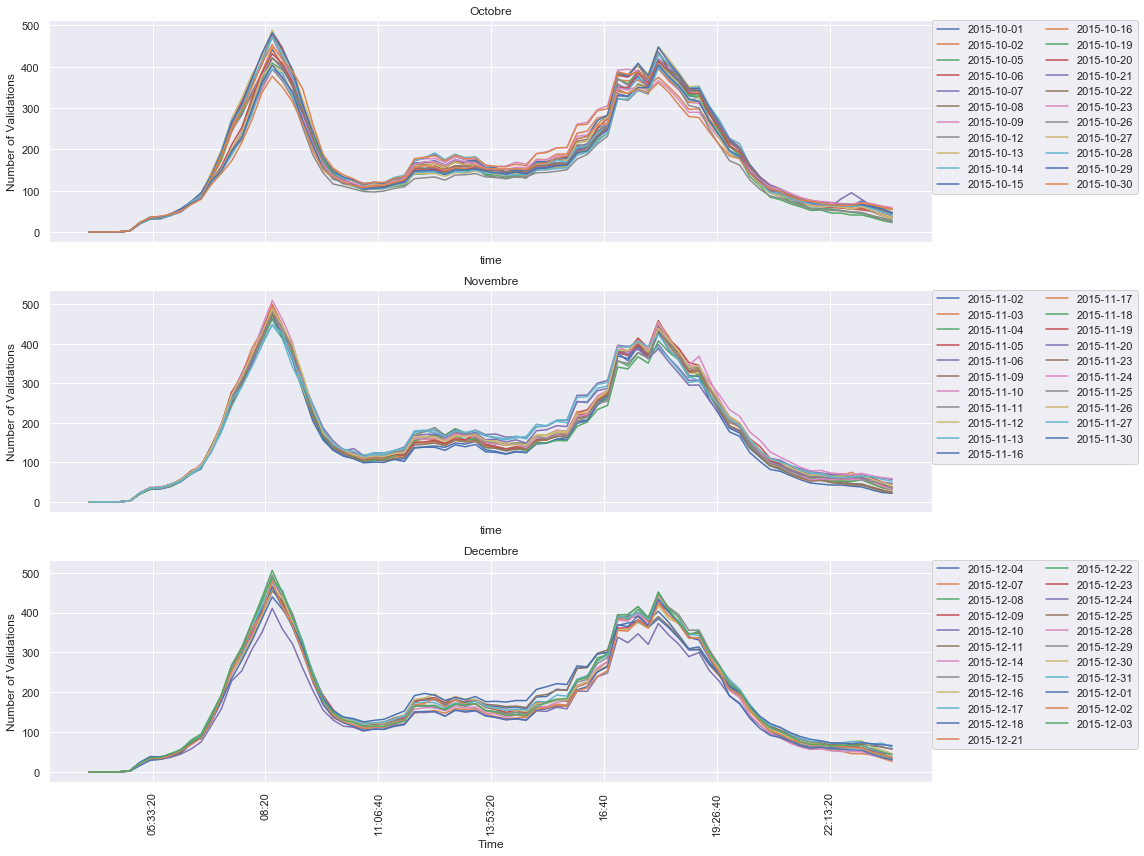

In [23]:
f, ax = plt.subplots(3, figsize=(16, 12))
ax1 = wdm_15m.loc[:, dict_wd_oct.values()].plot(ax=ax[0])
ax1.set_xticklabels([])
ax1.set_ylabel('Number of Validations')
ax1.set_title('Octobre')
ax1.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

ax2 = wdm_15m.loc[:, dict_wd_nov.values()].plot(ax=ax[1])
ax2.set_xticklabels([])
ax2.set_ylabel('Number of Validations')
ax2.set_title('Novembre')
ax2.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

ax3 = wdm_15m.loc[:, dict_wd_dec.values()].plot(ax=ax[2])
ax3.set_xlabel('Time')
ax3.set_ylabel('Number of Validations')
ax3.set_title('Decembre')
plt.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), loc=2,
           ncol=2, borderaxespad=0.)

plt.xticks(rotation=90)
plt.tight_layout()

plt.show();

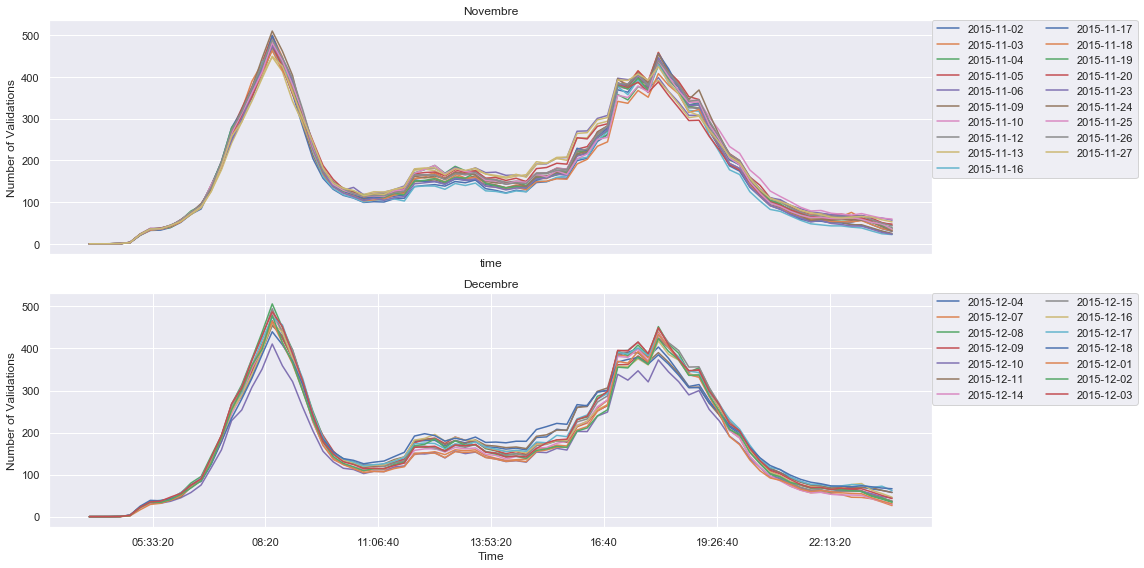

In [24]:
f, ax = plt.subplots(2, figsize=(16, 8))

ax1 = wdm_15mf.loc[:, dict_wd_novf.values()].plot(ax=ax[0])
ax1.set_xticks([])
ax1.set_ylabel('Number of Validations')
ax1.set_title('Novembre')
ax1.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

ax2 = wdm_15mf.loc[:, dict_wd_decf.values()].plot(ax=ax[1])
ax2.set_xlabel('Time')
ax2.set_ylabel('Number of Validations')
ax2.set_title('Decembre')
plt.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), loc=2,
           ncol=2, borderaxespad=0.)
plt.tight_layout()

plt.show();

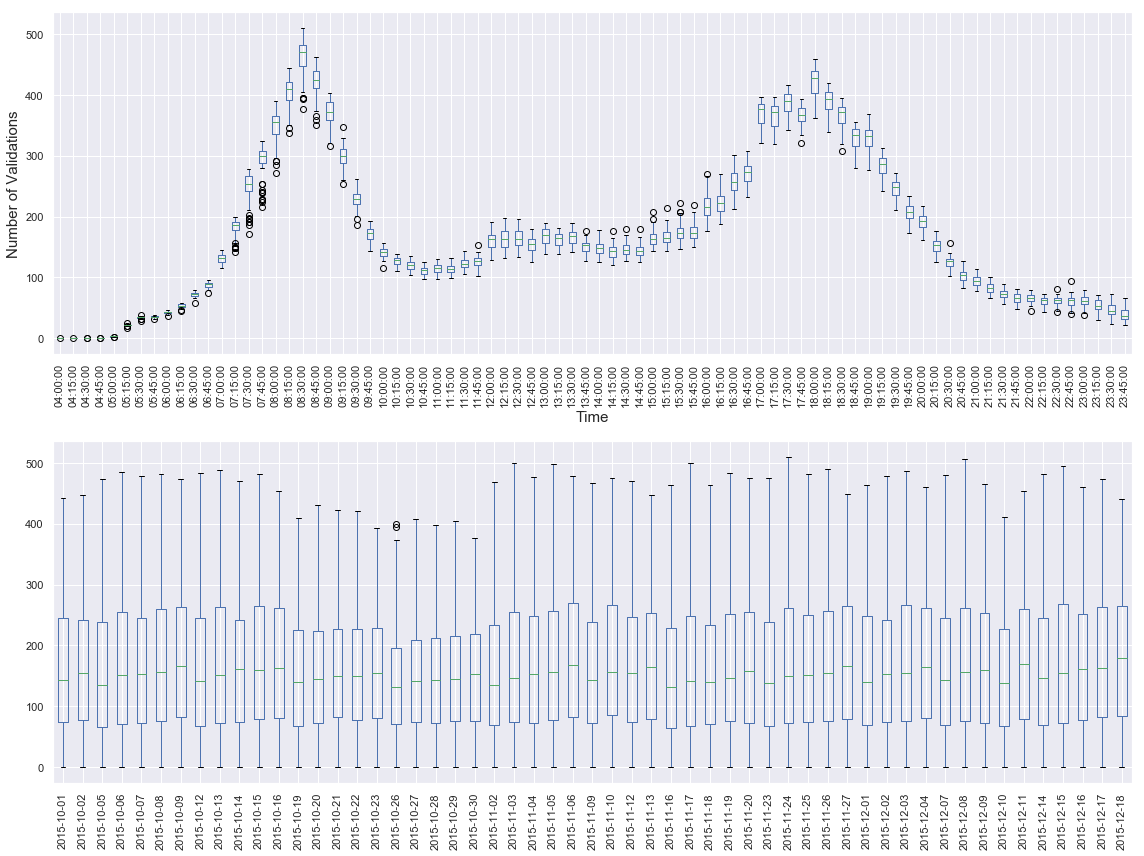

In [25]:
f, ax = plt.subplots(2, figsize=(16, 12))

ax1 = wdmt_15mf.boxplot(return_type='both', ax=ax[0])
ax[0].set_xlabel("Time", fontsize=15)
ax[0].set_ylabel("Number of Validations", fontsize=15)

for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)

ax2 = wdm_15mf.boxplot(return_type='both', ax=ax[1])
plt.xticks(rotation=90)

plt.tight_layout()
plt.show();

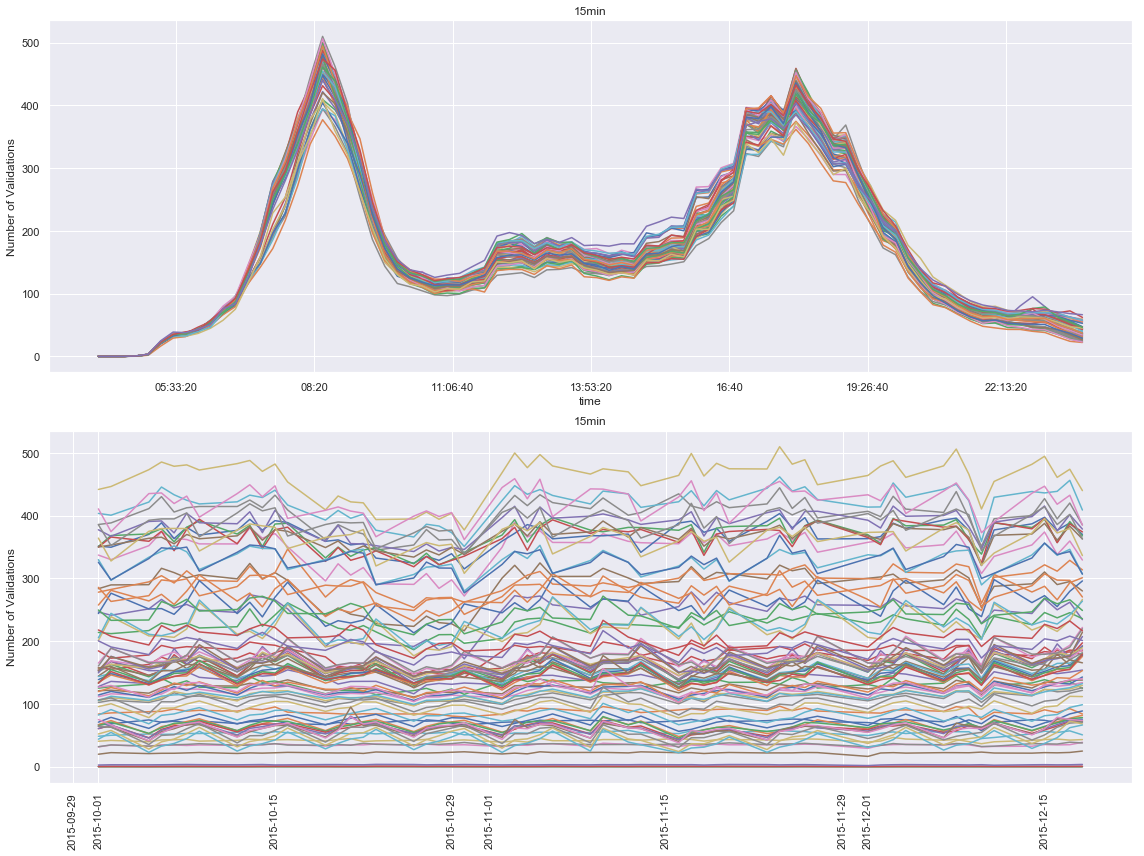

In [26]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 12))

wdm_15mf.plot(ax=ax1, legend=False)
ax1.set_ylabel('Number of Validations'); ax1.set_title('15min')

ax2 = wdmt_15mf.plot(ax=ax2, legend=False)
ax2.set_ylabel('Number of Validations'); ax2.set_title('15min')

plt.xticks(rotation=90)
plt.tight_layout()

plt.show();

### Autocorrelation Plots

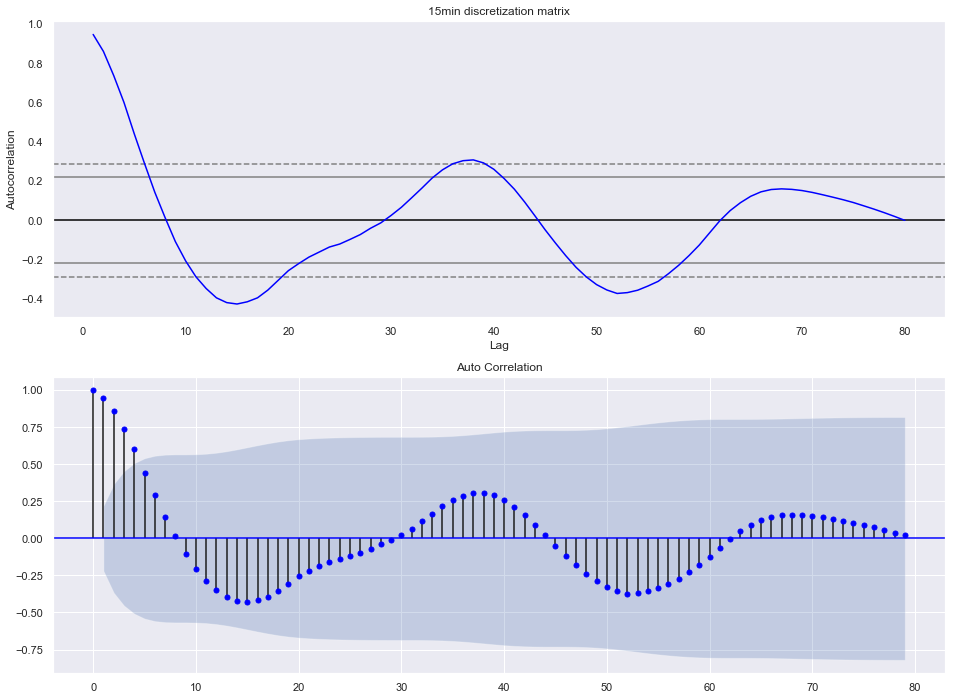

In [27]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 12))

autocorrelation_plot(wdmt_15mf.mean(), ax=ax1, c='blue')
ax1.set_title('15min discretization matrix')

plot_acf(wdmt_15mf.mean(), ax=ax2, c='blue', title='Auto Correlation')

plt.show();

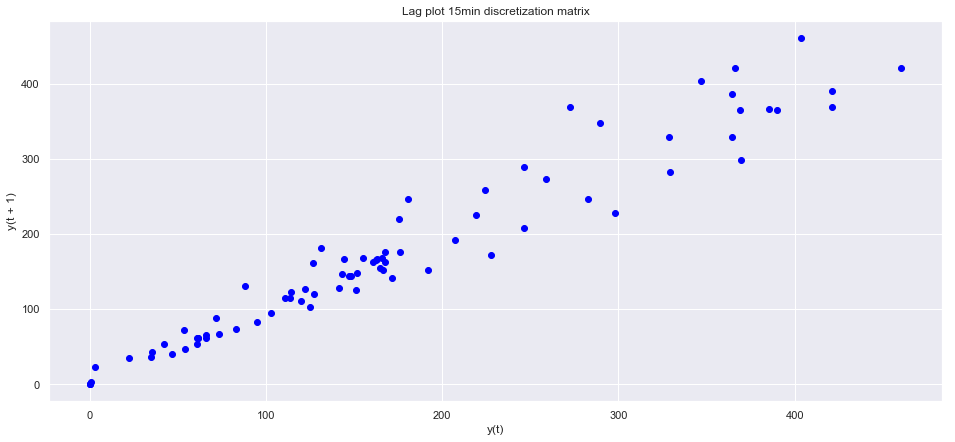

In [28]:
plt.figure(figsize=(16, 7))

lag_plot(wdmt_15mf.mean(), c='blue')
plt.title('Lag plot 15min discretization matrix')

# plot_pacf(wdmt_15mf.mean(), ax=ax[1], c='blue', title='Partial Auto Correlation')

plt.show();

### Dropping some subway stations

In [29]:
dico = dict_w
X = data_matrix_15m.loc[dico.values()]

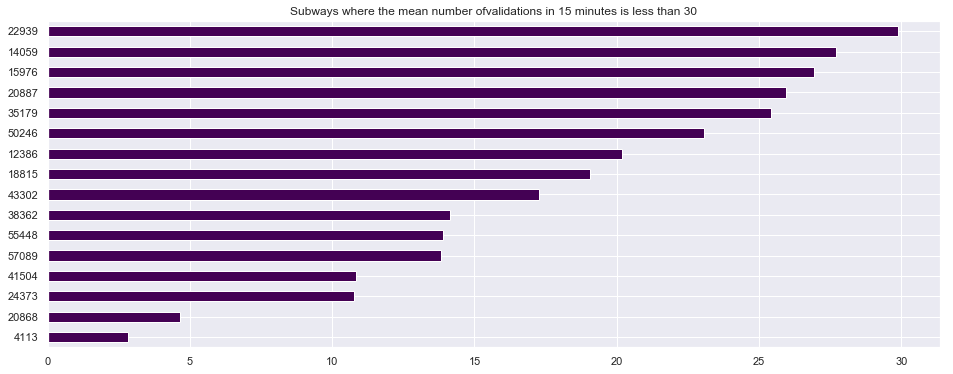

In [30]:
# Plot the station's id where the number of validations is less than the
# defined number 'nb_val' below
nb_val = 30
m = X.mean(axis=0).T.mean()
m[m < nb_val].sort_values().plot(kind='barh', grid=True, 
                                 cmap='viridis', 
                                 title="Subways where the mean number of"\
                                 "validations in 15 minutes is less than "\
                                 "{}".format(nb_val),
                                 figsize=(16, 6));

# Delete the stations where the mean number of validations is between 3 and 6
stations_to_del = [4113, 20868]
X.drop(columns=stations_to_del, inplace=True)